# Import Packages

In [133]:
import pandas as pd
import numpy as np
import pandas as pd 
import re
import os
from datetime import datetime
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
import plotly.tools as tls
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
sns.set()

In [134]:
p = "YlGnBu"
p2 = "YlGn"
p3 = "Greys"

# Load Data

In [135]:
df = pd.read_csv("c:/Users/shank_000/OneDrive/Desktop/IDS Assignment-1/2019_Cluster-DSE-IDS_A1_PS2.csv",sep=',')
df.head()

Job ID                        Agency Posting Type  # Of Positions  \
0   87990  DEPARTMENT OF BUSINESS SERV.     Internal               1   
1   97899  DEPARTMENT OF BUSINESS SERV.     Internal               1   
2  132292         NYC HOUSING AUTHORITY     External              52   
3  132292         NYC HOUSING AUTHORITY     Internal              52   
4  133921         NYC HOUSING AUTHORITY     Internal              50   

                                      Business Title  \
0                                    Account Manager   
1           EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT   
2  Maintenance Worker - Technical Services-Heatin...   
3  Maintenance Worker - Technical Services-Heatin...   
4                                  Temporary Painter   

              Civil Service Title Title Code No Level  \
0  CONTRACT REVIEWER (OFFICE OF L         40563     1   
1  ADMINISTRATIVE BUSINESS PROMOT         10009    M3   
2              MAINTENANCE WORKER         90698     0   
3              MAINTENANCE WORKER         90698     0   
4                         PAINTER         91830     0   

               Job Category Full-Time/Part-Time indicator  ...  \
0                       NaN                           NaN  ...   
1                       NaN                             F  ...   
2  Maintenance & Operations                             F  ...   
3  Maintenance & Operations                             F  ...   
4  Maintenance & Operations                             F  ...   

                              Additional Information  \
0  Salary range for this position is: $42,405 - $...   
1                                                NaN   
2  1.  A Motor Vehicle Driverâ€™s License valid i...   
3  1.  A Motor Vehicle Driverâ€™s License valid i...   
4  SPECIAL NOTE:    1.  This is a temporary assig...   

                                            To Apply Hours/Shift  \
0                                                NaN         NaN   
1  In addition to applying through this website, ...         NaN   
2                      Click the "Apply Now" button.         NaN   
3                      Click the "Apply Now" button.         NaN   
4                      Click the "Apply Now" button.         NaN   

  Work Location 1 Recruitment Contact  \
0             NaN                 NaN   
1             NaN                 NaN   
2             NaN                 NaN   
3             NaN                 NaN   
4             NaN                 NaN   

                               Residency Requirement             Posting Date  \
0  New York City residency is generally required ...  2011-06-24T00:00:00.000   
1  New York City residency is generally required ...  2012-01-26T00:00:00.000   
2               NYCHA has no residency requirements.  2013-10-24T00:00:00.000   
3               NYCHA has no residency requirements.  2013-10-24T00:00:00.000   
4                NYCHA has no residency requirement.  2014-01-09T00:00:00.000   

  Post Until          Posting Updated             Process Date  
0        NaN  2011-06-24T00:00:00.000  2019-11-26T00:00:00.000  
1        NaN  2012-01-26T00:00:00.000  2019-11-26T00:00:00.000  
2        NaN  2013-12-12T00:00:00.000  2019-11-26T00:00:00.000  
3        NaN  2013-12-12T00:00:00.000  2019-11-26T00:00:00.000  
4        NaN  2014-01-08T00:00:00.000  2019-11-26T00:00:00.000  

[5 rows x 28 columns]

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 28 columns):
Job ID                           3020 non-null int64
Agency                           3020 non-null object
Posting Type                     3020 non-null object
# Of Positions                   3020 non-null int64
Business Title                   3020 non-null object
Civil Service Title              3020 non-null object
Title Code No                    3020 non-null object
Level                            3020 non-null object
Job Category                     3018 non-null object
Full-Time/Part-Time indicator    2811 non-null object
Salary Range From                3020 non-null float64
Salary Range To                  3020 non-null float64
Salary Frequency                 3020 non-null object
Work Location                    3020 non-null object
Division/Work Unit               3020 non-null object
Job Description                  3020 non-null object
Minimum Qual Requirements    

# Data cleaning & Feature engineering

In [137]:
# helper functions
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color='white',
                     width=1024, height=720).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

def parse_categories(x):
    l = x.replace('&', ',').split(',')
    l = [x.strip().rstrip(',') for x in l]
    key_categories.extend(l)

def parse_keywords(x, l):
    x = x.lower()
    tokens = nltk.word_tokenize(x)
    stop_words = set(stopwords.words('english'))
    token_l = [w for w in tokens if not w in stop_words and w.isalpha()]
    l.extend(token_l)
    
def preferred_skills(x):
    kwl = []
    df[df.job_category==x].preferred_skills.dropna().apply(parse_keywords, l=kwl)
    kwl = pd.Series(kwl)
    return kwl.value_counts()[:20]


# Select required columns

In [138]:
df.drop(['Recruitment Contact', 'Post Until'], axis=1, inplace=True)
df.columns = ['id', 'agency', 'posting_type', 'number_of_positions', 'business_title', 'civil_service_title', 'title_code_number', 'level', 'job_category', 'full-time/part-time', 'salary_range_low', 'salary_range_high', 'salary_frequency', 'work_location', 'work_unit', 'job_description', 'minimum_requirements', 'preferred_skills', 'additional_info', 'to_apply', 'shift', 'work_location_1', 'residency_requirement', 'posting_date', 'posting_updated', 'process_date' ]

In [139]:
df['Average Salary']=(df['salary_range_low'] + df['salary_range_high'])/2
df.head()

id                        agency posting_type  number_of_positions  \
0   87990  DEPARTMENT OF BUSINESS SERV.     Internal                    1   
1   97899  DEPARTMENT OF BUSINESS SERV.     Internal                    1   
2  132292         NYC HOUSING AUTHORITY     External                   52   
3  132292         NYC HOUSING AUTHORITY     Internal                   52   
4  133921         NYC HOUSING AUTHORITY     Internal                   50   

                                      business_title  \
0                                    Account Manager   
1           EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT   
2  Maintenance Worker - Technical Services-Heatin...   
3  Maintenance Worker - Technical Services-Heatin...   
4                                  Temporary Painter   

              civil_service_title title_code_number level  \
0  CONTRACT REVIEWER (OFFICE OF L             40563     1   
1  ADMINISTRATIVE BUSINESS PROMOT             10009    M3   
2              MAINTENANCE WORKER             90698     0   
3              MAINTENANCE WORKER             90698     0   
4                         PAINTER             91830     0   

               job_category full-time/part-time  ...  \
0                       NaN                 NaN  ...   
1                       NaN                   F  ...   
2  Maintenance & Operations                   F  ...   
3  Maintenance & Operations                   F  ...   
4  Maintenance & Operations                   F  ...   

                                    preferred_skills  \
0  â€¢\tExcellent interpersonal and organizationa...   
1                                                NaN   
2  1.  A High School Diploma or GED.  2.  CDL Dri...   
3  1.  A High School Diploma or GED.  2.  CDL Dri...   
4                                                NaN   

                                     additional_info  \
0  Salary range for this position is: $42,405 - $...   
1                                                NaN   
2  1.  A Motor Vehicle Driverâ€™s License valid i...   
3  1.  A Motor Vehicle Driverâ€™s License valid i...   
4  SPECIAL NOTE:    1.  This is a temporary assig...   

                                            to_apply shift work_location_1  \
0                                                NaN   NaN             NaN   
1  In addition to applying through this website, ...   NaN             NaN   
2                      Click the "Apply Now" button.   NaN             NaN   
3                      Click the "Apply Now" button.   NaN             NaN   
4                      Click the "Apply Now" button.   NaN             NaN   

                               residency_requirement             posting_date  \
0  New York City residency is generally required ...  2011-06-24T00:00:00.000   
1  New York City residency is generally required ...  2012-01-26T00:00:00.000   
2               NYCHA has no residency requirements.  2013-10-24T00:00:00.000   
3               NYCHA has no residency requirements.  2013-10-24T00:00:00.000   
4                NYCHA has no residency requirement.  2014-01-09T00:00:00.000   

           posting_updated             process_date Average Salary  
0  2011-06-24T00:00:00.000  2019-11-26T00:00:00.000        53945.0  
1  2012-01-26T00:00:00.000  2019-11-26T00:00:00.000       111377.0  
2  2013-12-12T00:00:00.000  2019-11-26T00:00:00.000        53244.0  
3  2013-12-12T00:00:00.000  2019-11-26T00:00:00.000        53244.0  
4  2014-01-08T00:00:00.000  2019-11-26T00:00:00.000           35.0  

[5 rows x 27 columns]

# Check total preferred skills

In [140]:
df.preferred_skills.value_counts()


ERROR: #NAME?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [141]:
key_categories = []
df.job_category.dropna().apply(parse_categories)
key_categories = pd.Series(key_categories)
key_categories = key_categories[key_categories!='']
popular_categories = key_categories.value_counts().iloc[:25]

## Salary frequency

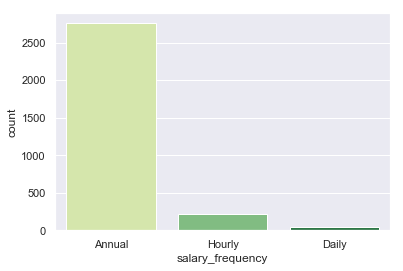

In [142]:
sns.countplot(x='salary_frequency', data=df, palette=p2)

## Jobs with highest low salary range (annual)

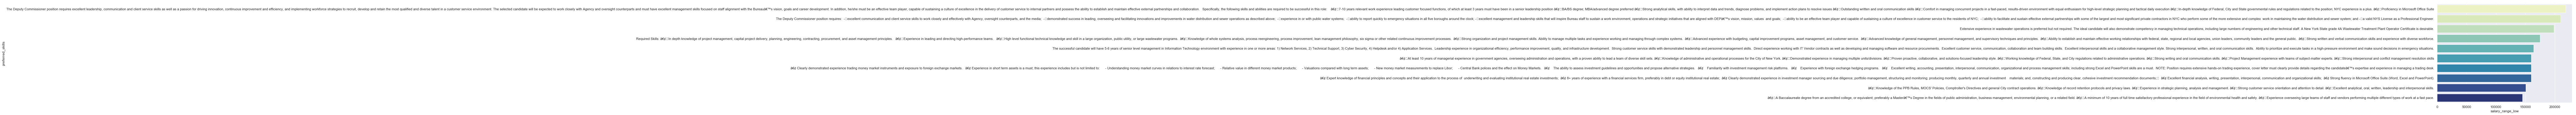

In [143]:
salary_table = df[['preferred_skills', 'salary_range_low', 'salary_range_high']]
jobs_highest_low_range = pd.DataFrame(salary_table.groupby(['preferred_skills'])['salary_range_low'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='preferred_skills', x='salary_range_low', data=jobs_highest_low_range, palette=p)

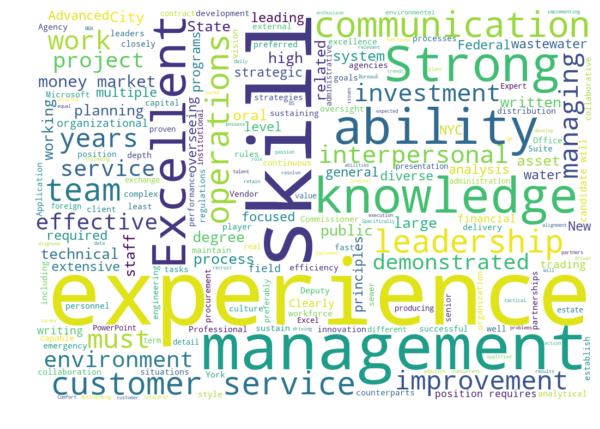

In [144]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(jobs_highest_low_range['preferred_skills'].tolist()))

## Jobs with highest high salary range (annual)

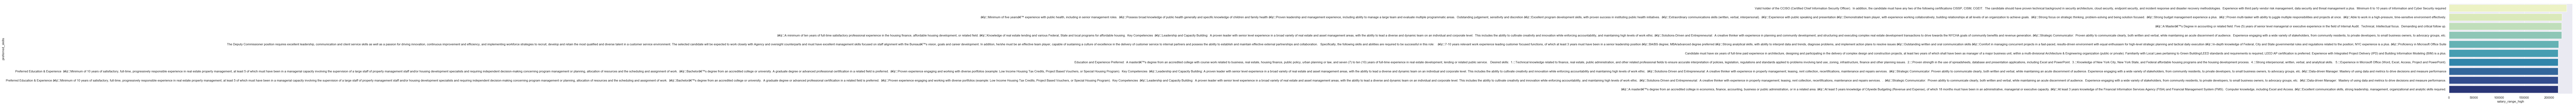

In [145]:
jobs_highest_high_range = pd.DataFrame(salary_table.groupby(['preferred_skills'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='preferred_skills', x='salary_range_high', data=jobs_highest_high_range, palette=p)

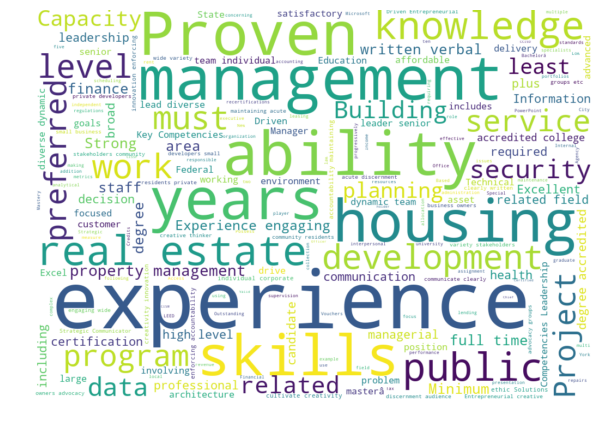

In [146]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(jobs_highest_high_range['preferred_skills'].tolist()))

## Highest paying jobs on an hourly basis

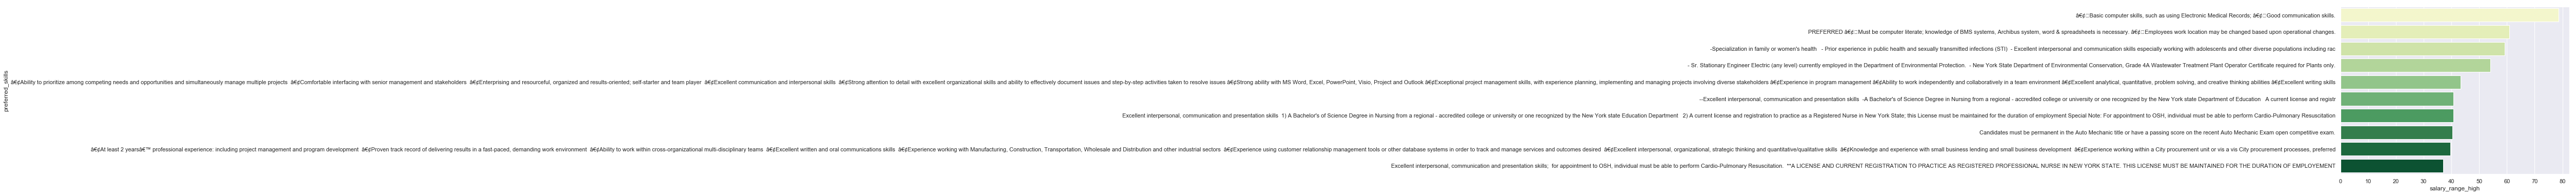

In [147]:
hourly_jobs = df[df.salary_frequency == 'Hourly']
jobs_highest_high_range_hourly = pd.DataFrame(hourly_jobs.groupby(['preferred_skills'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(y='preferred_skills', x='salary_range_high', data=jobs_highest_high_range_hourly, palette=p2)

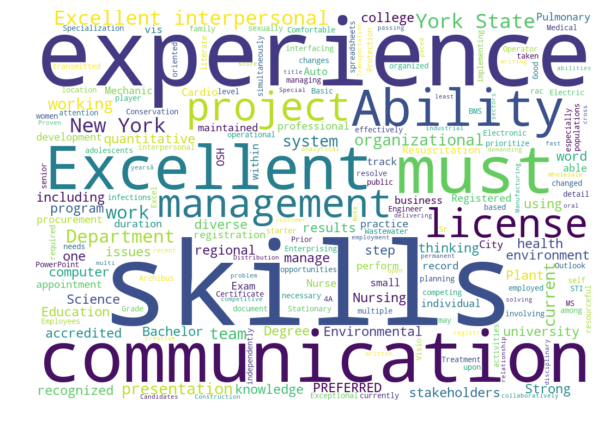

In [148]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(jobs_highest_high_range_hourly['preferred_skills'].tolist()))

# Most in-demand job categories

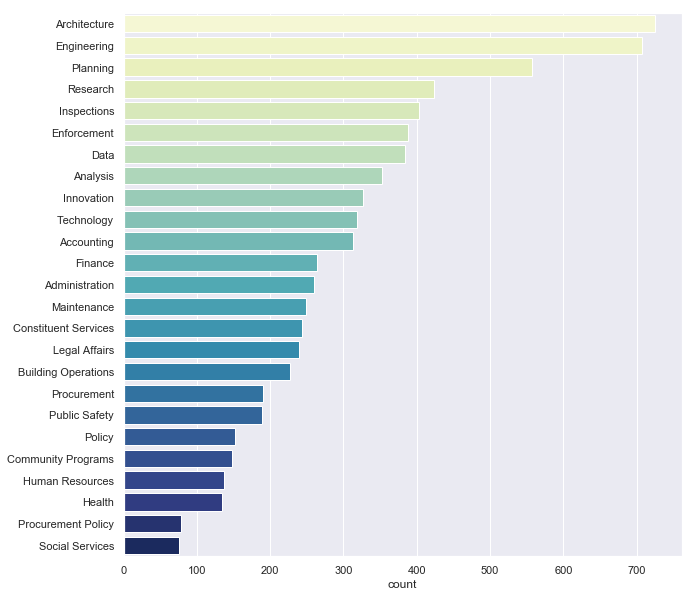

In [149]:
plt.figure(figsize=(10,10))
sns.countplot(y=key_categories, order=popular_categories.index, palette=p)

## Most popular preferred skills per job category

In [150]:
popular_categories = df.job_category.value_counts()[:10]
popular_categories

Engineering, Architecture, & Planning        545
Technology, Data & Innovation                283
Legal Affairs                                239
Building Operations & Maintenance            209
Public Safety, Inspections, & Enforcement    181
Finance, Accounting, & Procurement           164
Constituent Services & Community Programs    144
Administration & Human Resources             137
Health                                       134
Policy, Research & Analysis                  118
Name: job_category, dtype: int64

In [151]:
preferred_skills(popular_categories.index[0]).iplot(title='engineering', kind='bar', color='khaki')

In [152]:
preferred_skills(popular_categories.index[1]).iplot(title='technology', kind='bar', color='deepskyblue')

In [159]:
preferred_skills(popular_categories.index[2]).iplot(title='Legal Affairs', kind='bar', color='orange') 

In [157]:
preferred_skills(popular_categories.index[3]).iplot(title='Building Operations', kind='bar', color='purple') 

In [160]:
preferred_skills(popular_categories.index[4]).iplot(title='Public Safety', kind='bar', color='powderblue')

In [161]:
preferred_skills(popular_categories.index[5]).iplot(title='Finance', kind='bar', color='green')

In [162]:
preferred_skills(popular_categories.index[6]).iplot(title='Constituent Services', kind='bar', color='powderblue')

In [163]:
preferred_skills(popular_categories.index[7]).iplot(title='Administration', kind='bar', color='darkolivegreen')

In [164]:
preferred_skills(popular_categories.index[8]).iplot(title='Health', kind='bar', color='yellow')                                       

In [166]:
preferred_skills(popular_categories.index[9]).iplot(title='Policy', kind='bar', color='pink')                                       

# salary ranges based on job category

C:\Users\shank_000\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



Text(0.5, 0.98, 'Salary Range by Job Category')

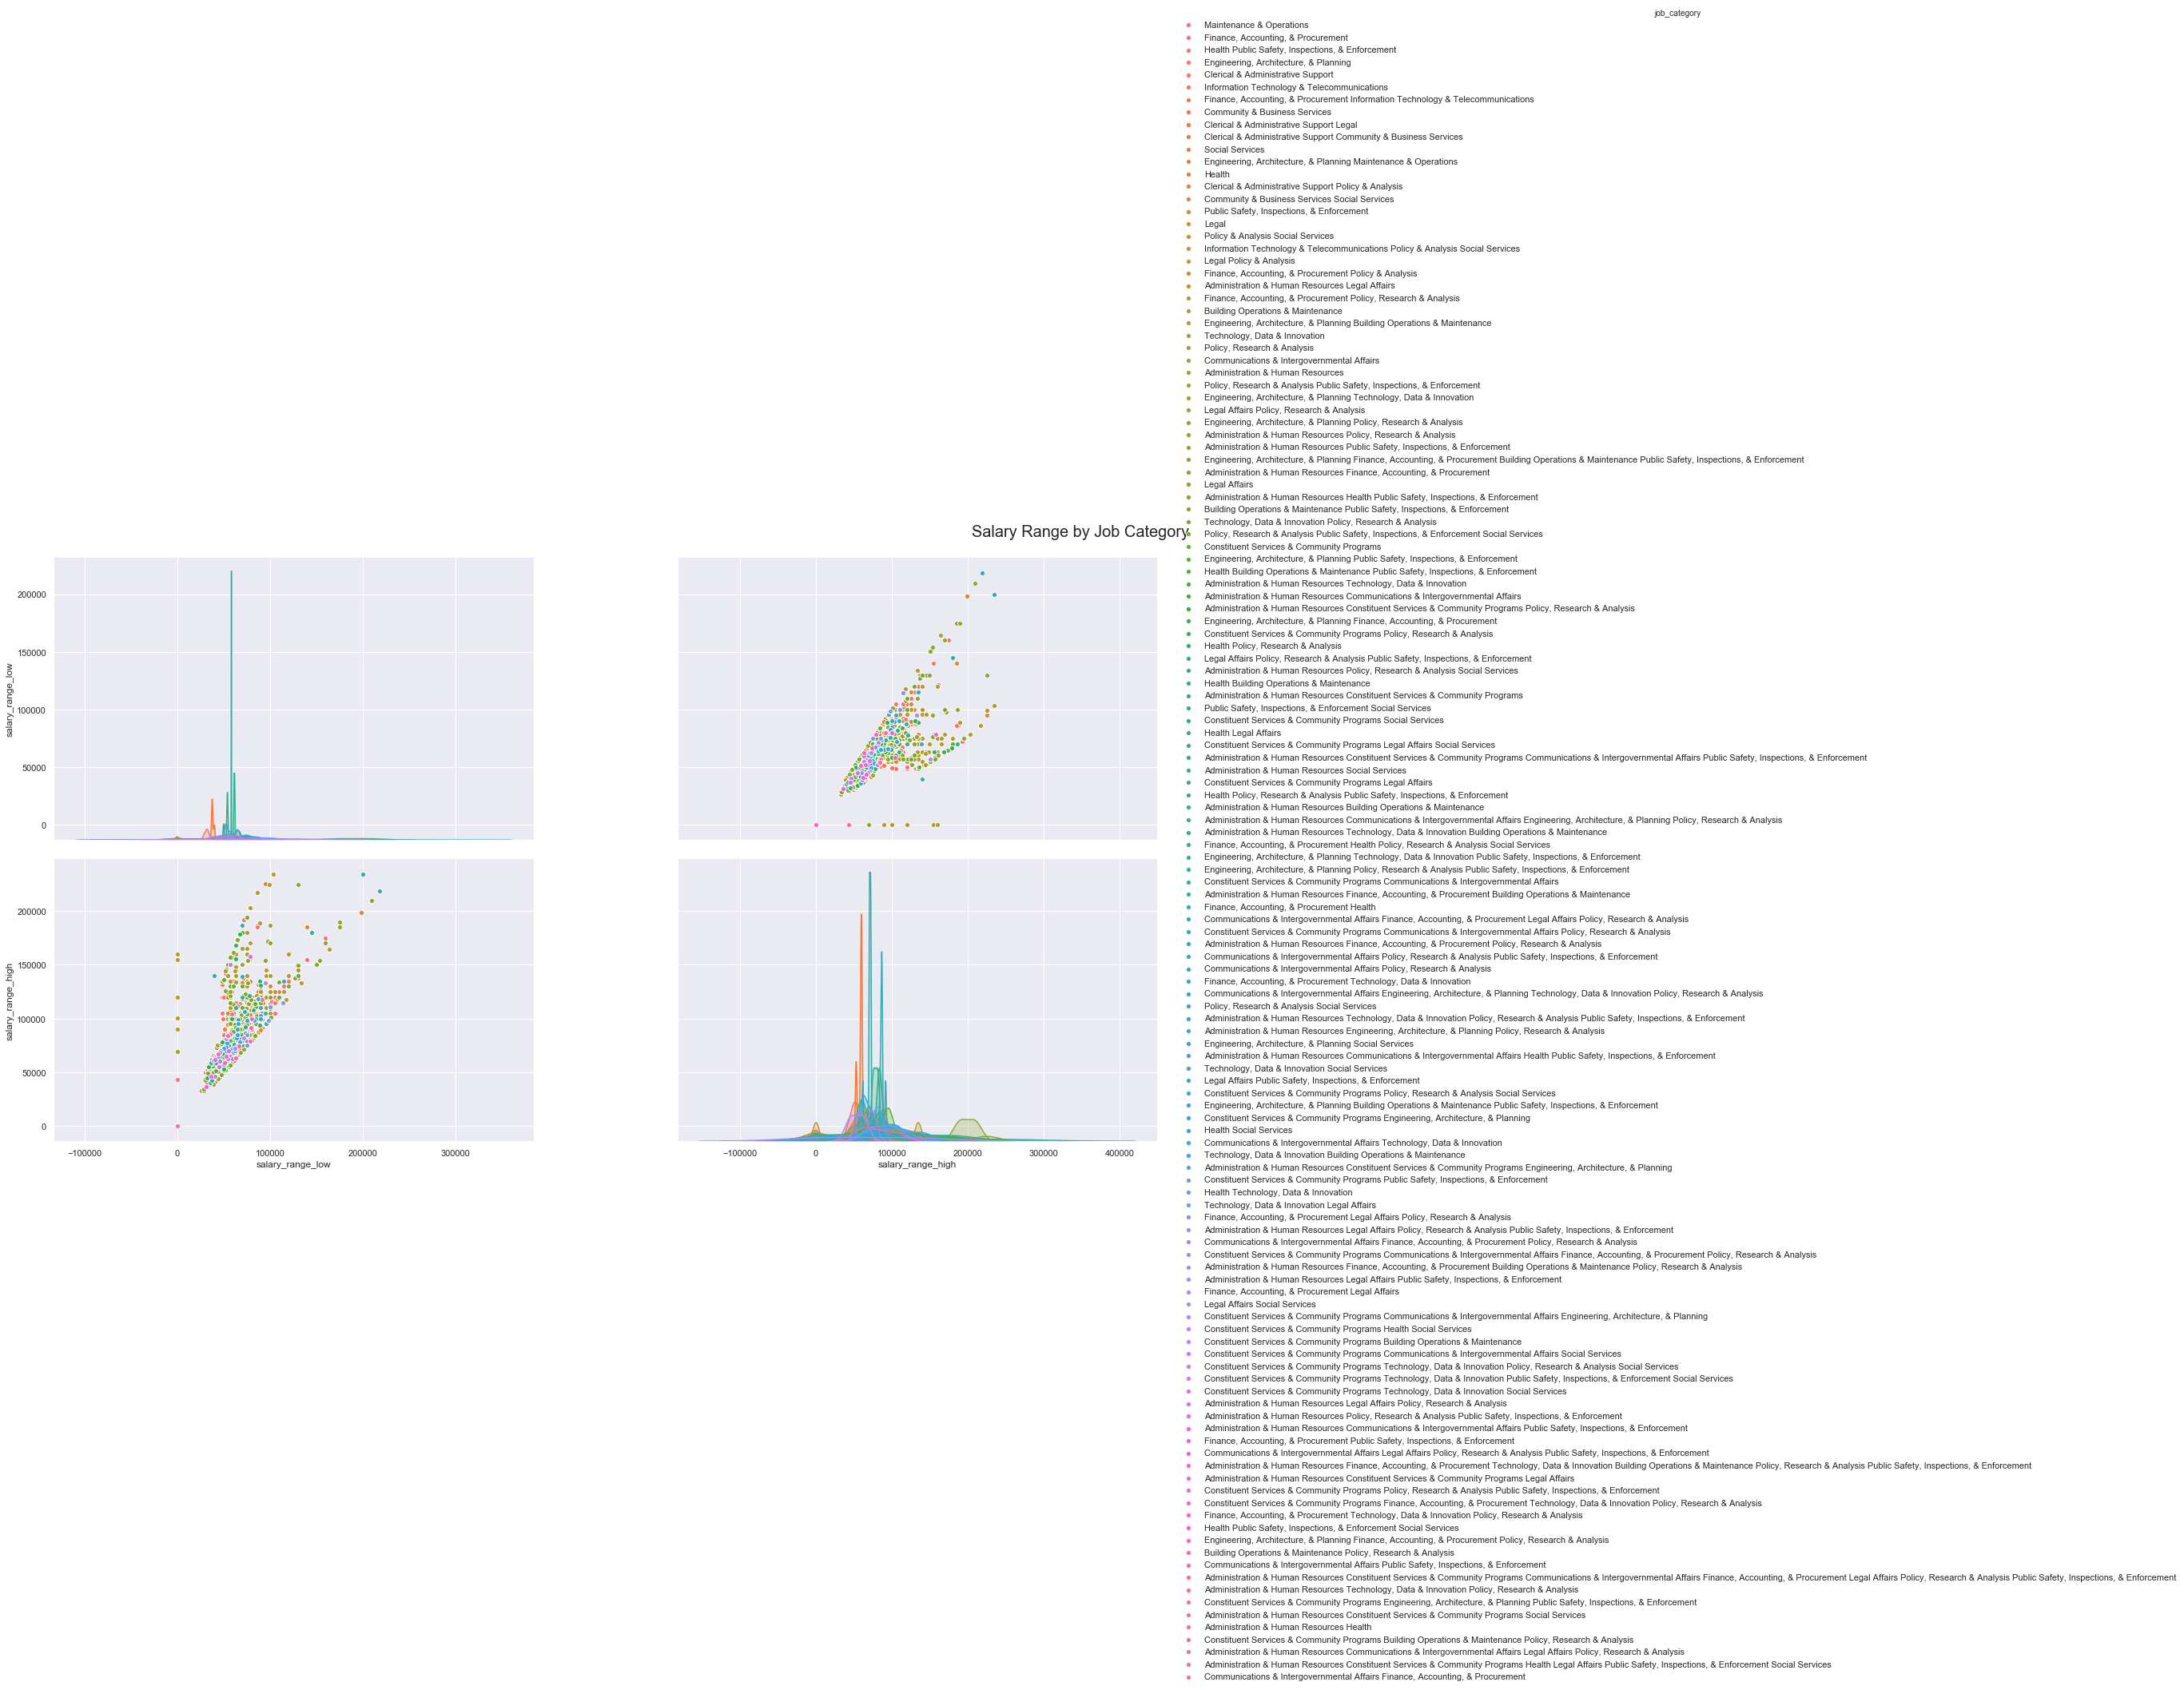

In [190]:
#PairWise Plot
cols = ['job_category', 
        'salary_range_low', 
        'salary_range_high',
        'minimum_requirements']
        
pp = sns.pairplot(data=df[cols], 
                  hue='job_category',
                  size=5.8, aspect=1.8, 
                 )
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Salary Range by Job Category', fontsize=20)

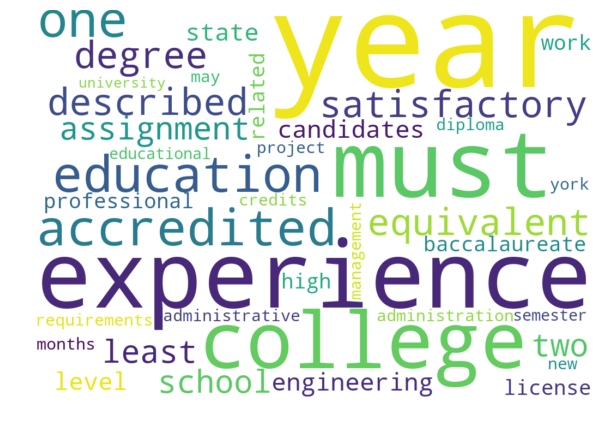

In [191]:
qualification_keywords = ['Years']
df.minimum_requirements.dropna().apply(parse_keywords, l=qualification_keywords)
plt.figure(figsize=(10, 8))
counter = Counter(qualification_keywords)
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))